In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys

In [3]:
path_ref  ='/Users/rempel/ScienceProjects/MURaM_Git/MURaM_main/TEST/Test_3D/3D/'
path_test ='/Users/rempel/ScienceProjects/MURaM_Git/MURaM_main/TEST/Test_3D_1/3D/'

iter=0

thresh = 1e-4

In [4]:
trans=[0,1,2]

def inttostring(ii,ts_size=6):

  str_num = str(ii)

  for bb in range(len(str_num),ts_size,1):
    str_num = '0'+str_num
  
  return str_num

def read_var_3d(dir,var,iter,layout=None):
  
  h = np.loadtxt(dir+'Header.'+inttostring(iter,ts_size=6))

  size = h[0:3].astype(int)
  dx   = h[3:6]
  time = h[6]
                               
  tmp = np.fromfile(dir+var+'.'+ inttostring(iter,ts_size=6),dtype=np.float32)
  tmp = tmp.reshape([size[2],size[1],size[0]])
    
  if layout != None :
      tmp = tmp.transpose(layout)
  
  return tmp,dx,size,time

def hdiff(var1,var2,minval):
    var1_m = np.mean(np.abs(var1),axis=(0,1))
    diff_m = np.mean(np.abs(var1-var2),axis=(0,1))
    diff_m = diff_m/np.maximum(var1_m,minval)
    return diff_m

In [5]:
rho_ref,dx,size,time=read_var_3d(path_ref,'result_prim_0',iter,trans)
rho_test,dx,size,time=read_var_3d(path_test,'result_prim_0',iter,trans)

T_ref,dx,size,time=read_var_3d(path_ref,'eosT',iter,trans)
T_test,dx,size,time=read_var_3d(path_test,'eosT',iter,trans)

V_ref,dx,size,time=read_var_3d(path_ref,'result_prim_1',iter,trans)
V_test,dx,size,time=read_var_3d(path_test,'result_prim_1',iter,trans)

E_ref,dx,size,time=read_var_3d(path_ref,'result_prim_4',iter,trans)
E_test,dx,size,time=read_var_3d(path_test,'result_prim_4',iter,trans)

B_ref,dx,size,time=read_var_3d(path_ref,'result_prim_5',iter,trans)
B_test,dx,size,time=read_var_3d(path_test,'result_prim_5',iter,trans)

Qrad_ref,dx,size,time=read_var_3d(path_ref,'Qtot',iter,trans)
Qrad_test,dx,size,time=read_var_3d(path_test,'Qtot',iter,trans)

Qcor_ref,dx,size,time=read_var_3d(path_ref,'QxCor',iter,trans)
Qcor_test,dx,size,time=read_var_3d(path_test,'QxCor',iter,trans)

cond_ref,dx,size,time=read_var_3d(path_ref,'result_prim_8',iter,trans)
cond_test,dx,size,time=read_var_3d(path_test,'result_prim_8',iter,trans)

if iter > 0:
    Qamb_ref,dx,size,time=read_var_3d(path_ref,'Qamb',iter,trans)
    Qamb_test,dx,size,time=read_var_3d(path_test,'Qamb',iter,trans)
else:
    Qamb_ref=np.zeros(size)
    Qamb_test=np.zeros(size)

In [6]:
ref=[rho_ref,T_ref,V_ref,E_ref,B_ref,cond_ref,Qrad_ref,Qcor_ref,Qamb_ref]
test=[rho_test,T_test,V_test,E_test,B_test,cond_test,Qrad_test,Qcor_test,Qamb_test]
names=['Density','Temperature','Velocity','Energy','Magnetic Field','Conduction','Q_Radiation','Q_Corona','Q_Ambipolar']
plot_range_min=[1e-15,1e3,1e4,0.1,0.1,1e3,1e-4,1e-4,1e-4]
minval=[1e-20,1e-20,1e-20,1e-20,1,1e-20,1e-20,1e-20,1e-20]

In [7]:
for v in range(9):
    difference=np.amax(hdiff(ref[v],test[v],minval[v]))
    if difference > thresh:
        sys.stdout.write("\033[1;31m")
    else:
        sys.stdout.write("\033[0;32m")
    print(names[v].ljust(14),':',difference)
sys.stdout.write("\033[0;0m")

Density        : 0.0
Temperature    : 0.0
Velocity       : 0.0
Energy         : 0.0
Magnetic Field : 0.0
Conduction     : 0.0
Q_Radiation    : 1.0650981e-07
Q_Corona       : 0.0
Q_Ambipolar    : 0.0


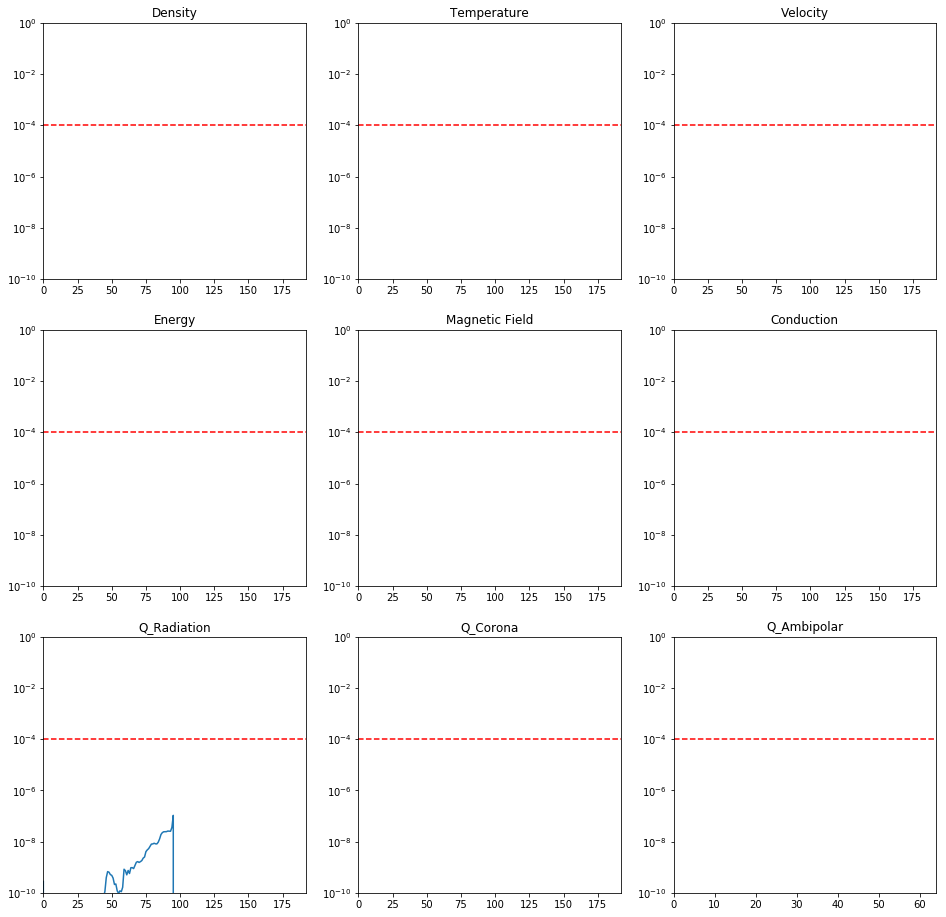

In [8]:
vmin=1e-10

plt.figure(figsize=(16,16))

for v in range(9):
    diff=hdiff(ref[v],test[v],minval[v])
    size=diff.shape
    plt.subplot(3,3,1+v)
    plt.plot(diff)
    plt.ylim(vmin, 1)
    plt.yscale('log')
    plt.xlim(0,size[0])
    plt.title(names[v])
    plt.xlim(0,size[0])
    plt.hlines(thresh,0,size[0],linestyles='dashed',color='red')

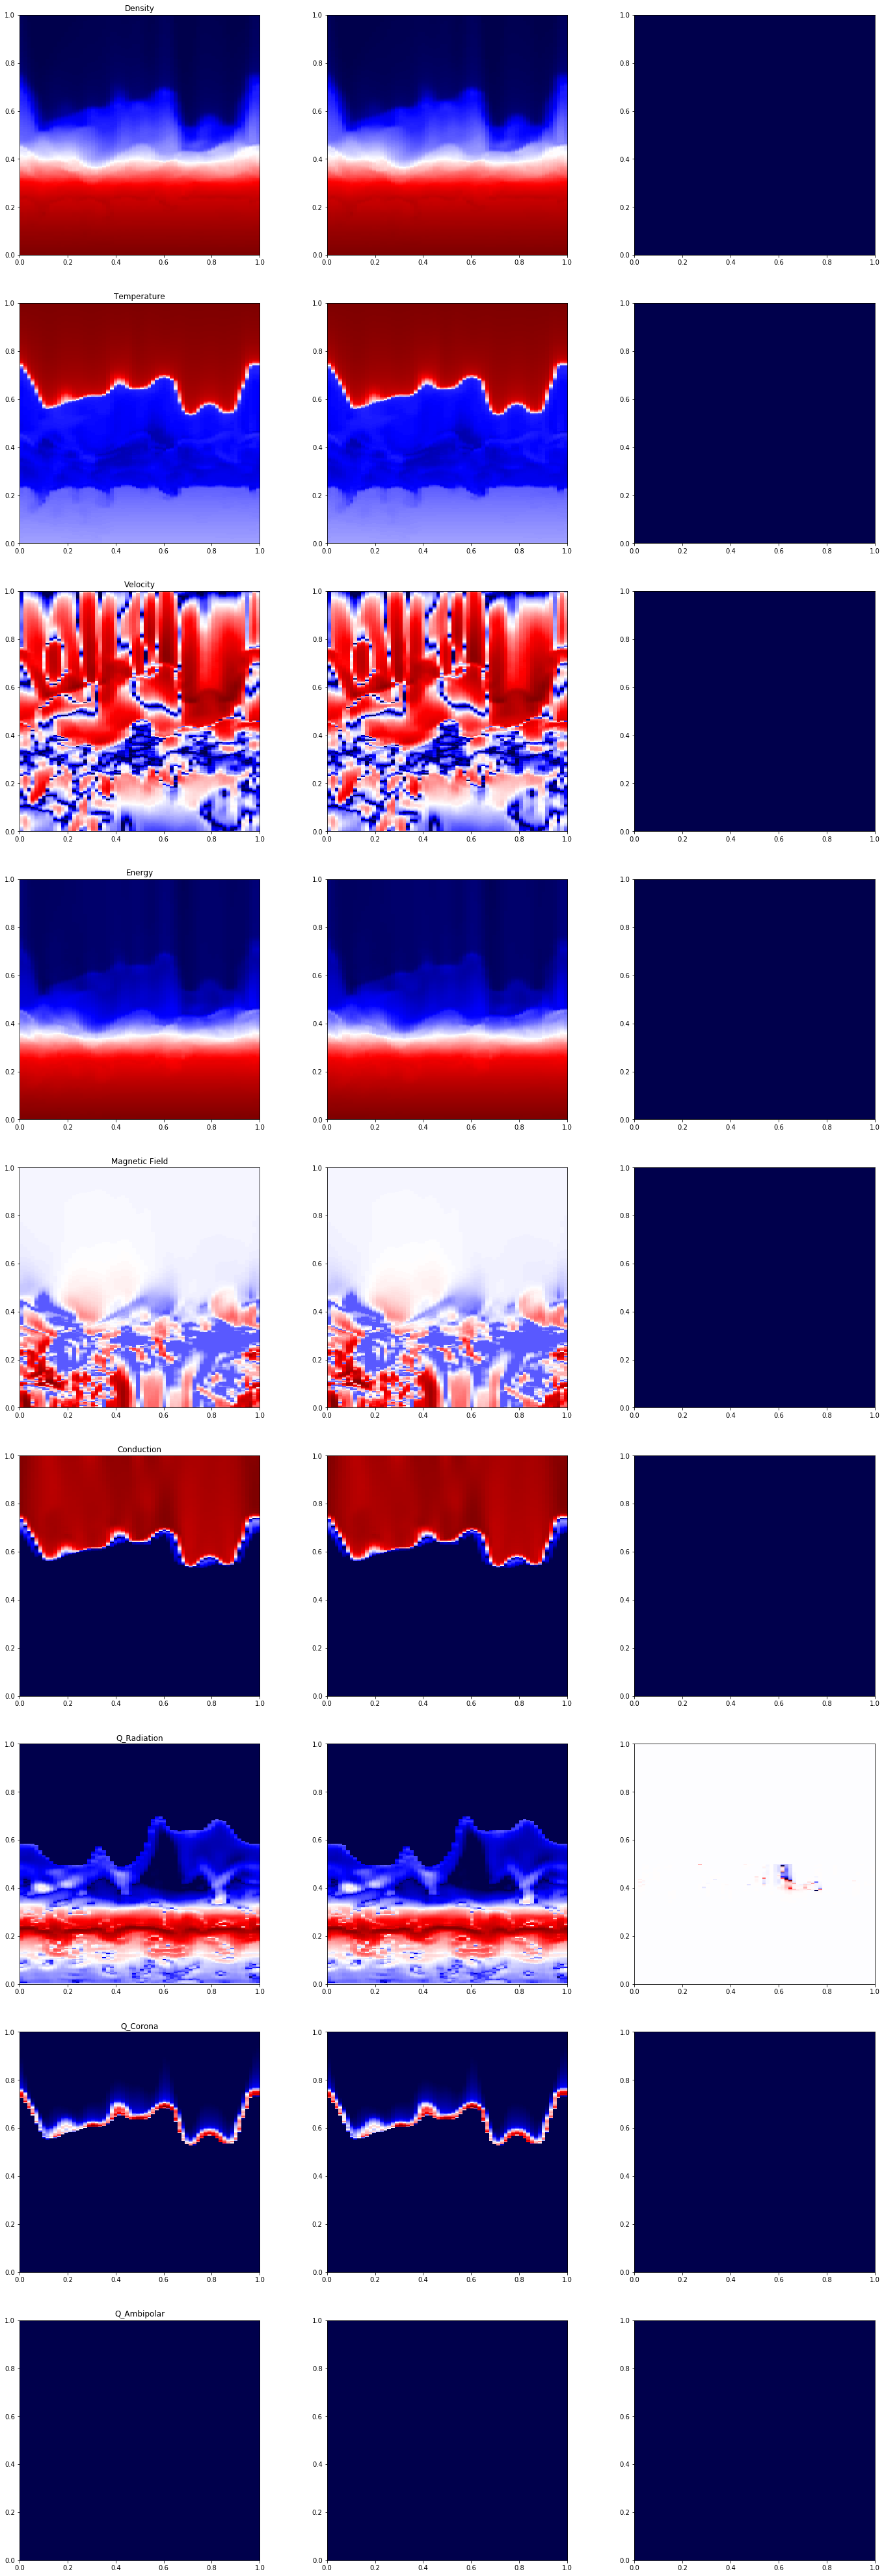

In [9]:
plt.figure(figsize=(24,72))


for v in range(9):
    q_ref  = np.maximum(np.abs(ref[v]),minval[v])
    q_test = np.maximum(np.abs(test[v]),minval[v])
    
    f=np.abs(q_test/q_ref-1.0)
    wmax=np.sum(f,axis=(1,2))
    wpos=np.argwhere(wmax == np.amax(wmax))[0]
    zpos=wpos[0]
    
    vmr=np.minimum(plot_range_min[v],np.amax(q_ref[zpos,:,:]))
    vmt=np.minimum(plot_range_min[v],np.amax(q_test[zpos,:,:]))

    plt.subplot(9,3,1+3*v)
    plt.imshow(np.log10(q_ref[zpos,:,:].T),origin='left',cmap='seismic',extent=[0,1,0,1],vmin=np.log10(vmr))
    plt.title(names[v])
    plt.subplot(9,3,2+3*v)
    plt.imshow(np.log10(q_test[zpos,:,:].T),origin='left',cmap='seismic',extent=[0,1,0,1],vmin=np.log10(vmt))
    plt.subplot(9,3,3+3*v)
    v_ref=10*np.abs(q_test[zpos,:,:]/q_ref[zpos,:,:]-1).mean()
    plt.imshow((q_test[zpos,:,:].T/q_ref[zpos,:,:].T-1),origin='left',cmap='seismic',extent=[0,1,0,1],vmin=-v_ref,vmax=v_ref)